In [1]:
import os, sys

import pandas
import datetime as dt
import numpy as np
import pandas
import scipy.stats as stats
from scipy.optimize import minimize

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

CURRENT_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, CURRENT_PATH)
sys.path.insert(0, CURRENT_PATH + '\\Modules')

### PD/LGD curves

In [2]:
norm_cdf = lambda x: stats.norm.cdf(x)
norm_icdf = lambda x: stats.norm.ppf(x)

def merton_PD_RR(V_0, D, mu, sigma, T):
    dd = np.log(V_0 / D) + (mu - 0.5 * sigma**2) * T
    dd = dd / (sigma * np.sqrt(T))
    pd = norm_cdf(-dd)

    rr = V_0 / D * np.exp(mu * T)
    rr = rr * norm_cdf(-dd - sigma * np.sqrt(T)) / pd

    return pd, rr

def merton_PD_to_RR(pd, sigma, T):  # , V_0, D, mu, sigma, T
    dd = -norm_icdf(pd)
    coef = np.exp(dd * sigma * np.sqrt(T) + T/2 * sigma**2)  # V_0 / D * np.exp(mu * T)
    rr = coef * norm_cdf(-dd - sigma * np.sqrt(T)) / pd

    return rr

In [3]:
V_0 = 100
D = 80
sigma = 0.3
mu = 0.1
T = 1

Ds = np.arange(40, 150)
pd_per_D, rr_per_D = merton_PD_RR(V_0, Ds, mu, sigma, T)

Vs = np.arange(50, 150)
pd_per_V, rr_per_V = merton_PD_RR(Vs, D, mu, sigma, T)

sigmas = np.arange(0.1, 1.0, 0.2)
pd_per_sigma, rr_per_sigma = merton_PD_RR(V_0, D, mu, sigmas, T)

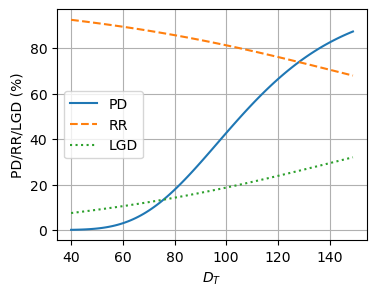

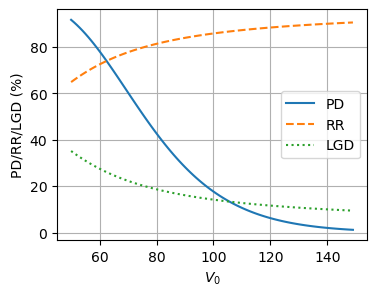

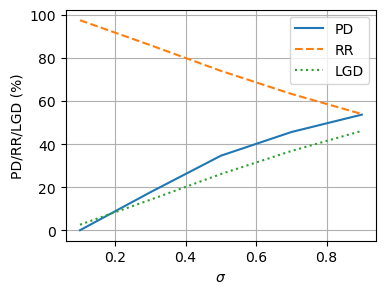

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(Ds, 100 * pd_per_D, label='PD')
plt.plot(Ds, 100 * rr_per_D, linestyle='dashed', label='RR')
plt.plot(Ds, 100 * (1 - rr_per_D), linestyle='dotted', label='LGD')
plt.grid()
plt.xlabel(r'$D_T$')
plt.ylabel('PD/RR/LGD (%)')
plt.legend()

# plt.savefig(CURRENT_PATH + '\\Output\\PD_DT.png', format='png', dpi=300, bbox_inches = "tight")

plt.figure(figsize=(4, 3))
plt.plot(Vs, 100 * pd_per_V, label='PD')
plt.plot(Vs, 100 * rr_per_V, linestyle='dashed', label='RR')
plt.plot(Vs, 100 * (1 - rr_per_V), linestyle='dotted', label='LGD')
plt.grid()
plt.xlabel(r'$V_0$')
plt.ylabel('PD/RR/LGD (%)')
plt.legend()

# plt.savefig(CURRENT_PATH + '\\Output\\PD_V0.png', format='png', dpi=300, bbox_inches = "tight")

plt.figure(figsize=(4, 3))
plt.plot(sigmas, 100 * pd_per_sigma, label='PD')
plt.plot(sigmas, 100 * rr_per_sigma, linestyle='dashed', label='RR')
plt.plot(sigmas, 100 * (1 - rr_per_sigma), linestyle='dotted', label='LGD')
plt.grid()
plt.xlabel(r'$\sigma$')
plt.ylabel('PD/RR/LGD (%)')
plt.legend()

# plt.savefig(CURRENT_PATH + '\\Output\\PD_sigma.png', format='png', dpi=300, bbox_inches = "tight")

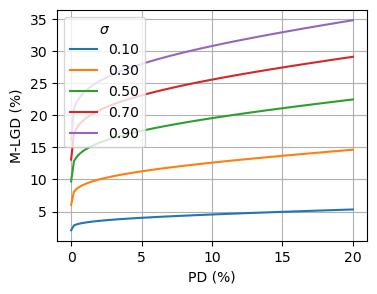

In [5]:
plt.figure(figsize=(4, 3))

pds = np.linspace(1e-5, 0.2, 100)

for sigma in sigmas:
    plt.plot(100 * pds, 100 * (1 - merton_PD_to_RR(pds, sigma, T)), label='{:.2f}'.format(sigma))

plt.legend(title=r'$\sigma$', loc='upper left')
plt.xlabel('PD (%)')
plt.ylabel('M-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_lgd_sigma', format='png', dpi=300, bbox_inches = "tight")

In [6]:
x_ = np.linspace(1e-3, 0.1, 30)
shocks = np.linspace(0.0, 0.1, 20)

sigma = 0.8
elgd = 0.25

ldg_surface = np.array([(1 - merton_PD_to_RR(x_ + s, sigma, T)) for s in shocks])

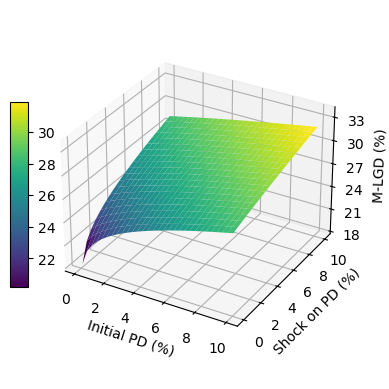

In [7]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = ldg_surface

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('M-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.set_zticks(np.round(ax.get_zticks()))
ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)

# plt.savefig(CURRENT_PATH + '\\Output\\surface_structural_lgd.png', format='png', dpi=300, bbox_inches = "tight")

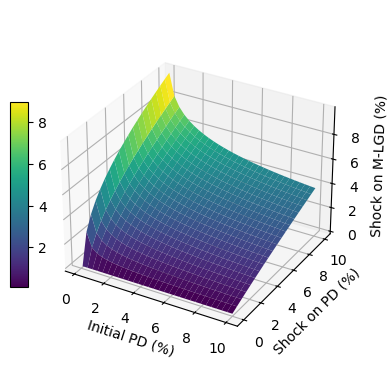

In [8]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = ldg_surface
Z = Z - Z[0]

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('Shock on M-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.set_box_aspect(aspect=None, zoom=0.83)

# plt.savefig(CURRENT_PATH + '\\Output\\surface_structural_lgd_shock.png', format='png', dpi=300, bbox_inches = "tight")

### Infer parameters

##### Method historical

In [9]:
df_euronext_merton = pandas.read_csv(CURRENT_PATH + '\\Output\\merton_EURONEXT_^GSPC.csv', index_col=0)
df_euronext_merton = df_euronext_merton.loc[df_euronext_merton.date > '2021-12-31']
df_euronext_merton = df_euronext_merton.loc[df_euronext_merton.sigma_V < 2]

N = 5
df_euronext_merton['LGD_round'] = df_euronext_merton.LGD.apply(lambda x: N*np.round(x/N, 2))
df_euronext_merton['sigma_round'] = df_euronext_merton.sigma_V.apply(lambda x: N*np.round(x/N, 2))

In [10]:
np.corrcoef(df_euronext_merton.PD.apply(lambda x: norm_icdf(x)), df_euronext_merton.RR.apply(lambda x: norm_icdf(x)))

array([[ 1.        , -0.67908982],
       [-0.67908982,  1.        ]])

Text(0, 0.5, 'LGD (%)')

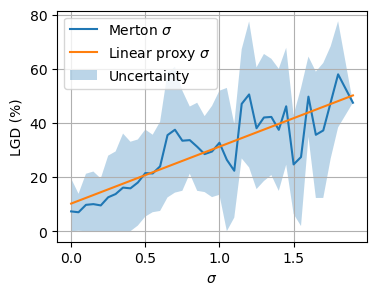

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

y_ = df_euronext_merton.loc[df_euronext_merton.sigma_round < 2.0, ['sigma_round', 'LGD']].groupby('sigma_round').mean()['LGD']
X_ = np.array(y_.index).reshape(-1, 1)
std = df_euronext_merton.loc[df_euronext_merton.sigma_round < 2.0, ['sigma_round', 'LGD']].groupby('sigma_round').std()['LGD'].fillna(0)
ass_e = [(y_ - std).apply(lambda x: max(0, x)), (y_ + std).apply(lambda x: max(0, x))]

lr.fit(y=y_, X=X_)
lr.coef_, lr.intercept_

plt.figure(figsize=(4, 3))
plt.plot(X_.flatten(), 100 * y_, label=r'Merton $\sigma$')
plt.plot(np.linspace(0, X_.max(), 100), 100 * lr.predict(np.linspace(0, X_.max(), 100).reshape(-1, 1)), label=r'Linear proxy $\sigma$')
plt.fill_between(X_.flatten(), 100 * ass_e[0].values, 100 * ass_e[1].values, alpha=0.3, label='Uncertainty')
plt.grid()
plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel('LGD (%)')

# plt.savefig(CURRENT_PATH + '\\Output\\linear_proxy_sigma', format='png', dpi=300, bbox_inches = "tight")

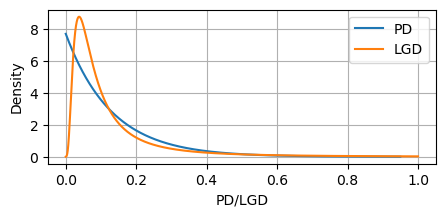

In [12]:
from scipy.stats import gamma, beta, t, invgamma, invgauss, expon

df_ = df_euronext_merton
distribution = expon
params = distribution.fit(df_.PD.astype(float))

plt.figure(figsize=(5, 2))
x = np.linspace(df_.PD.min(), df_.PD.max(), 10000)
plt.plot(x, distribution.pdf(x, *params), label='PD')

distribution = invgamma
params = distribution.fit(df_euronext_merton.LGD.astype(float))

x = np.linspace(1e-5, 1, 10000)
plt.plot(x, distribution.pdf(x, *params), label='LGD')
plt.grid()

plt.xlabel('PD/LGD')
plt.ylabel('Density')

plt.legend()

# plt.savefig(CURRENT_PATH + '\\Output\\merton_pd_lgd_distribution', format='png', dpi=300, bbox_inches = "tight")

##### Method numerical

Text(0, 0.5, 'LGD (%)')

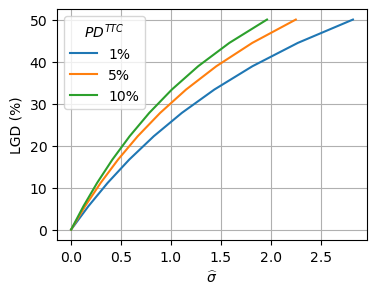

In [13]:
from scipy.optimize import minimize

plt.figure(figsize=(4, 3))

for pd in [0.01, 0.05, 0.1]:
    lgds_sigma = []
    for lgd in np.linspace(0, 0.5, 10):
        objective = lambda sigma: (1 - merton_PD_to_RR(pd, sigma, T) - lgd)**2
        solution = minimize(fun=objective, x0=0.5, method='BFGS', tol=0, options={'maxiter': 10000})
        lgds_sigma.append(solution.x[0])
    plt.plot(lgds_sigma, 100 * np.linspace(0, 0.5, 10), label='{:.0f}%'.format(100 * pd))

plt.grid()
plt.legend(title=r'$PD^{TTC}$')
plt.xlabel(r'$\widehat{\sigma}$')
plt.ylabel('LGD (%)')

# plt.savefig(CURRENT_PATH + '\\Output\\numerical_proxy_sigma', format='png', dpi=300, bbox_inches = "tight")